# Import libraries, set config

In [1]:
import sys
sys.path.append('..')

import os
import json
import joblib
import warnings
from collections import defaultdict
import numpy as np
import pandas as pd
from glob import glob
from optimizer.optimizer import Optimizer
from os import environ
from datetime import timedelta
from tqdm.auto import tqdm

import lightgbm as lgb

from eli5.sklearn import PermutationImportance
from shaphypetune import BoostBoruta

from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.model_selection import GroupKFold, StratifiedGroupKFold, GroupShuffleSplit, TimeSeriesSplit, train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import log_loss, mean_squared_error, precision_score

import torch

from colorama import Style, Fore

# Set environment variable
environ["ENV"] = "optimize"

from config.config import ConfigFactory
from indicators import indicators


class CFG:
    load = True
    create_dataset = True
    cls_target_ratio_tp = 1.031
    cls_target_ratio_sl = 1.031
    ttype = 'both'
    patterns_to_filter = ['MACD', 'STOCH_RSI']
    select_features = False
    train_NN = False
    train_LGBM = True
    n_repeats = 1
    n_folds = 5
    agg_periods = [24, 168, 720]
    agg_funcs = [np.min, np.max, np.mean, np.median, np.std]

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

tqdm.pandas()

warnings.simplefilter(action='ignore', category=(FutureWarning, pd.errors.PerformanceWarning))

# Load MACD buy data

In [2]:
work_timeframe = '1h'
higher_timeframe = '4h'
opt_limit = 100000

load = True
clean = True

ttype = 'buy'
pattern = ['MACD']
indicator_list = pattern
indicator_list_higher = ['Trend', 'MACD']

# Get configs
configs = ConfigFactory.factory(environ).configs
configs['Indicator_list'] = indicator_list
configs['Higher_TF_indicator_list'] = indicator_list_higher
configs['Timeframes']['work_timeframe'] = work_timeframe
configs['Timeframes']['higher_timeframe'] = higher_timeframe

optim_dict = {
                'MACD': {
                          "fastperiod": [14],
                          "slowperiod": [28],
                          "signalperiod": [11]
                        }
             }

if CFG.load:
  print(f'Timeframe is {work_timeframe}/{higher_timeframe}, trade type is {ttype}')
  opt = Optimizer(pattern, optim_dict, clean, **configs)
  stat = opt.optimize(pattern, ttype, opt_limit, load, 'ml')

Timeframe is 1h/4h, trade type is buy
Number of combinations is 1


  0%|          | 0/1 [00:00<?, ?it/s]


Load the datasets...
Binance
OKEX
ByBit
MEXC
ByBitPerpetual
BinanceFutures
OKEXSwap
MEXCFutures


100%|██████████| 1/1 [07:30<00:00, 450.75s/it]


# Load MACD sell data

In [3]:
load = False
clean = False

ttype = 'sell'
pattern = ['MACD']
indicator_list = pattern
indicator_list_higher = ['Trend', 'MACD']

# Get configs
configs = ConfigFactory.factory(environ).configs
configs['Indicator_list'] = indicator_list
configs['Higher_TF_indicator_list'] = indicator_list_higher
configs['Timeframes']['work_timeframe'] = work_timeframe
configs['Timeframes']['higher_timeframe'] = higher_timeframe

optim_dict = {
                'MACD': {
                          "fastperiod": [14],
                          "slowperiod": [28],
                          "signalperiod": [11]
                        }
             }

if CFG.load:
  print(f'Timeframe is {work_timeframe}/{higher_timeframe}, trade type is {ttype}')
  opt = Optimizer(pattern, optim_dict, clean, **configs)
  stat = opt.optimize(pattern, ttype, opt_limit, load, 'ml')

Timeframe is 1h/4h, trade type is sell
Number of combinations is 1


100%|██████████| 1/1 [02:41<00:00, 161.19s/it]


# Prepare data

In [34]:
tmp_df_1h

,time,open,high,low,close,volume
0,2022-12-20 20:00:00,16833.62,16857.74,16783.60,16815.83,7905.38456
1,2022-12-20 21:00:00,16815.83,16868.00,16767.00,16835.76,7837.47776
2,2022-12-20 22:00:00,16835.75,16915.92,16834.83,16900.30,8048.24599
3,2022-12-20 23:00:00,16900.93,16926.99,16838.56,16859.30,8066.17450
4,2022-12-21 00:00:00,16858.86,16894.73,16833.51,16877.19,6018.54394
...,...,...,...,...,...,...
7237,2023-11-10 05:00:00,36722.20,36912.90,36632.20,36897.60,3588.80300
7238,2023-11-10 06:00:00,36897.60,36955.00,36757.20,36772.60,3006.14800
7239,2023-11-10 07:00:00,36772.60,36847.40,36665.10,36830.00,3468.34900
7240,2023-11-10 08:00:00,36830.00,36841.40,36689.70,36792.90,2088.87600


In [38]:
tmp_df_1h = pd.read_pickle(f'../optimizer/ticker_dataframes/MASKUSDT_1h.pkl')
(tmp_df_1h['close'] * tmp_df_1h['volume']).rolling(24).sum().dropna().mean()

18444924.853099294

In [4]:
# Get configs
configs = ConfigFactory.factory(environ).configs

def get_file(ticker):
    ''' Find files buy ticker names, file names can be in different formats '''
    try:
        tmp_df_1h = pd.read_pickle(f'../optimizer/ticker_dataframes/{ticker}_1h.pkl')
        tmp_df_4h = pd.read_pickle(f'../optimizer/ticker_dataframes/{ticker}_4h.pkl')
    except FileNotFoundError:
        pass
    else:
        return tmp_df_1h, tmp_df_4h
    
    try:
        tmp_df_1h = pd.read_pickle(f'../optimizer/ticker_dataframes/{ticker[:-4]}-{ticker[-4:]}_1h.pkl')
        tmp_df_4h = pd.read_pickle(f'../optimizer/ticker_dataframes/{ticker[:-4]}-{ticker[-4:]}_4h.pkl')
    except FileNotFoundError:
        pass
    else:
        return tmp_df_1h, tmp_df_4h
    
    try:
        tmp_df_1h = pd.read_pickle(f'../optimizer/ticker_dataframes/{ticker[:-4]}-{ticker[-4:]}-SWAP_1h.pkl')
        tmp_df_4h = pd.read_pickle(f'../optimizer/ticker_dataframes/{ticker[:-4]}-{ticker[-4:]}-SWAP_4h.pkl')
    except FileNotFoundError:
        pass
    else:
        return tmp_df_1h, tmp_df_4h
    
    return None, None

def add_indicators(df, df_higher, ttype, configs):
    # add RSI
    rsi = indicators.RSI(ttype, configs)
    df = rsi.get_indicator(df, '', '', 0)
    # add RSI
    stoch = indicators.STOCH(ttype, configs)
    df = stoch.get_indicator(df, '', '', 0)
    # add ATR
    atr = indicators.ATR(ttype, configs)
    df = atr.get_indicator(df, '', '', 0)
     # add MACD
    macd = indicators.MACD(ttype, configs)
    # df = macd.get_indicator(df, '', '', 0)
    df_higher = macd.get_indicator(df_higher, '', '', 0)
    # add Trend
    trend = indicators.Trend(ttype, configs)
    # df = trend.get_indicator(df, '', '', 0)
    df_higher = trend.get_indicator(df_higher, '', '', 0)
    higher_features = ['time', 'linear_reg', 'linear_reg_angle', 'macd', 'macdhist', 
                        'macd_dir', 'macdsignal', 'macdsignal_dir']
    # merge higher timeframe indicators with working timeframe
    df = pd.merge(df, df_higher[higher_features], how='left', on='time')
    df.ffill(inplace=True)
    df = df.dropna()
    return df.reset_index(drop=True)

def create_train_df(df, ttype, configs, target_offset, first, last, step):
    ''' Create train dataset from signal statistics and ticker candle data'''
    train_df = pd.DataFrame()
    tickers = df['ticker'].unique()
    
    for ticker in tqdm(tickers):
        # get signals with current ticker
        signal_df = df[df['ticker'] == ticker]
        times = signal_df['time']
        
        # load candle history of this ticker
        tmp_df_1h, tmp_df_4h = get_file(ticker)

        # add indicators 
        try:
            tmp_df_1h = add_indicators(tmp_df_1h, tmp_df_4h, ttype, configs)
        except TypeError:
            continue

        # add historical data for current ticker
        for i, t in enumerate(times.to_list()):
            pass_cycle, sl = False, False
            pattern = signal_df.iloc[i, signal_df.columns.get_loc('pattern')]
            row = tmp_df_1h.loc[tmp_df_1h['time'] == t, :].reset_index(drop=True)
            
            for i in range(first, last + step, step):
                time_prev = t + timedelta(hours= -i)
                try:
                    row_tmp = tmp_df_1h.loc[tmp_df_1h['time'] == time_prev, :].reset_index(drop=True)
                    row_tmp.columns = [c + f'_prev_{i}' for c in row_tmp.columns]
                except IndexError:
                    pass_cycle = True
                    break
                row = pd.concat([row, row_tmp.iloc[:,1:]], axis=1)
                row['ticker'] = ticker
                row['pattern'] = pattern
                
            if pass_cycle:
                continue

            row['target'] = 0
            row['ttype'] = ttype
            
            # If ttype = buy and during the selected period high price was higher than close_price * target_ratio
            # and earlier low price wasn't lower than close_price / target_ratio, than target is True, else target is False.
            # Similarly for ttype = sell 
            close_price = tmp_df_1h.loc[tmp_df_1h['time'] == t, 'close']

            if close_price.shape[0] == 0:
                break
            
            close_price = close_price.values[0]
            
            for i in range(1, target_offset + 1):
                time_next = t + timedelta(hours=i)
                target_buy = tmp_df_1h.loc[tmp_df_1h['time'] == time_next, 'high']
                target_sell = tmp_df_1h.loc[tmp_df_1h['time'] == time_next, 'low']
                
                if target_buy.shape[0] == 0 or target_sell.shape[0] == 0:
                    pass_cycle = True
                    break
                
                target_buy = target_buy.values[0]
                target_sell = target_sell.values[0]

                target_buy_tp = 1 if target_buy > close_price * CFG.cls_target_ratio_tp else 0
                target_buy_sl = 1 if target_buy > close_price * CFG.cls_target_ratio_sl else 0
                target_sell_tp = 1 if target_sell < close_price * (2 - CFG.cls_target_ratio_tp) else 0
                target_sell_sl = 1 if target_sell < close_price * (2 - CFG.cls_target_ratio_sl) else 0
                
                # set sl flag if price goes through stop-loss threshold before it goes through take-profit threshold
                if (row['ttype'].values == 'buy' and target_sell_sl == 1) or (row['ttype'].values == 'sell' and target_buy_sl == 1):
                    break
                
                if (row['ttype'].values == 'buy' and target_buy_tp == 1) or (row['ttype'].values == 'sell' and target_sell_tp == 1):
                    row['target'] = 1
                    break
            
            if pass_cycle:
                continue

            # add aggregates
            # for col in ['open', 'close', 'low', 'high', 'volume']:
            #     for period in CFG.agg_periods:
            #         for agg_func in CFG.agg_funcs:
            #             tmp_len = min(len(tmp_df_1h), period)
            #             stat_val = tmp_df_1h.iloc[-tmp_len:, tmp_df_1h.columns.get_loc(col)].rolling(period, min_periods=1).agg({'func': agg_func}).values[-1, 0]
            #             row[f'{col}_{agg_func.__name__}_{period}'] = stat_val
            
            # add data to the dataset
            if train_df.shape[0] == 0:
                train_df = row
            else:
                train_df = pd.concat([train_df, row])
    
    return train_df

if CFG.create_dataset:
    # for how long time (in hours) we want to predict
    target_offset = 96
    # first previous data point to collect for model training (value represents number of hours before signal point)
    first = 4
    # last previous data point to collect for model training (value represents number of hours before signal point)
    last = 192
    # step of previous data points collecting (total number of points to collect is (last - first + step) / step)
    step = 4

    # Buy
    # dataset with the signal statistics
    df = pd.read_pickle('signal_stat/buy_stat_1h.pkl')
    df = df[df['time'].dt.year > 1970]
    # dataset for model train
    train_buy = create_train_df(df, 'buy', configs, target_offset, first, last, step)
    train_buy = train_buy.dropna()

    # Sell
    # dataset with the signal statistics
    df = pd.read_pickle('signal_stat/sell_stat_1h.pkl')
    df = df[df['time'].dt.year > 1970]
    # dataset for model train
    train_sell = create_train_df(df, 'sell', configs, target_offset, first, last, step)
    train_sell = train_sell.dropna()

    train_buy = pd.concat([train_buy, train_sell[train_sell['ttype'] == 'buy']]).sort_values('time').reset_index(drop=True)
    train_sell = pd.concat([train_sell, train_buy[train_buy['ttype'] == 'sell']]).sort_values('time').reset_index(drop=True)

    train_buy = train_buy[train_buy['ttype'] == 'buy']
    train_sell = train_sell[train_sell['ttype'] == 'sell']

    train_buy.to_pickle(f'signal_stat/train_buy_{last}.pkl')
    train_sell.to_pickle(f'signal_stat/train_sell_{last}.pkl')

    # display(df.head())
    # display(df.shape)


  0%|          | 0/487 [00:00<?, ?it/s]

  0%|          | 0/488 [00:00<?, ?it/s]

# Check pattern / target distribution

In [5]:
train_buy[train_buy['ticker']=='GALAUSDT']

,time,open,high,low,close,volume,rsi,stoch_slowk,stoch_slowd,stoch_slowk_dir,stoch_slowd_dir,stoch_diff,atr,close_smooth,linear_reg,linear_reg_angle,macd,macdhist,macd_dir,macdsignal,macdsignal_dir,open_prev_4,high_prev_4,low_prev_4,close_prev_4,volume_prev_4,rsi_prev_4,stoch_slowk_prev_4,stoch_slowd_prev_4,stoch_slowk_dir_prev_4,stoch_slowd_dir_prev_4,stoch_diff_prev_4,atr_prev_4,close_smooth_prev_4,linear_reg_prev_4,linear_reg_angle_prev_4,macd_prev_4,macdhist_prev_4,macd_dir_prev_4,macdsignal_prev_4,macdsignal_dir_prev_4,ticker,pattern,open_prev_8,high_prev_8,low_prev_8,close_prev_8,volume_prev_8,rsi_prev_8,stoch_slowk_prev_8,stoch_slowd_prev_8,stoch_slowk_dir_prev_8,stoch_slowd_dir_prev_8,stoch_diff_prev_8,atr_prev_8,close_smooth_prev_8,linear_reg_prev_8,linear_reg_angle_prev_8,macd_prev_8,macdhist_prev_8,macd_dir_prev_8,macdsignal_prev_8,macdsignal_dir_prev_8,open_prev_12,high_prev_12,low_prev_12,close_prev_12,volume_prev_12,rsi_prev_12,stoch_slowk_prev_12,stoch_slowd_prev_12,stoch_slowk_dir_prev_12,stoch_slowd_dir_prev_12,stoch_diff_prev_12,atr_prev_12,close_smooth_prev_12,linear_reg_prev_12,linear_reg_angle_prev_12,macd_prev_12,macdhist_prev_12,macd_dir_prev_12,macdsignal_prev_12,macdsignal_dir_prev_12,open_prev_16,high_prev_16,low_prev_16,close_prev_16,volume_prev_16,rsi_prev_16,stoch_slowk_prev_16,stoch_slowd_prev_16,stoch_slowk_dir_prev_16,stoch_slowd_dir_prev_16,stoch_diff_prev_16,atr_prev_16,close_smooth_prev_16,linear_reg_prev_16,linear_reg_angle_prev_16,macd_prev_16,macdhist_prev_16,macd_dir_prev_16,macdsignal_prev_16,macdsignal_dir_prev_16,open_prev_20,high_prev_20,low_prev_20,close_prev_20,volume_prev_20,rsi_prev_20,stoch_slowk_prev_20,stoch_slowd_prev_20,stoch_slowk_dir_prev_20,stoch_slowd_dir_prev_20,stoch_diff_prev_20,atr_prev_20,close_smooth_prev_20,linear_reg_prev_20,linear_reg_angle_prev_20,macd_prev_20,macdhist_prev_20,macd_dir_prev_20,macdsignal_prev_20,macdsignal_dir_prev_20,open_prev_24,high_prev_24,low_prev_24,close_prev_24,volume_prev_24,rsi_prev_24,stoch_slowk_prev_24,stoch_slowd_prev_24,stoch_slowk_dir_prev_24,stoch_slowd_dir_prev_24,stoch_diff_prev_24,atr_prev_24,close_smooth_prev_24,linear_reg_prev_24,linear_reg_angle_prev_24,macd_prev_24,macdhist_prev_24,macd_dir_prev_24,macdsignal_prev_24,macdsignal_dir_prev_24,open_prev_28,high_prev_28,low_prev_28,close_prev_28,volume_prev_28,rsi_prev_28,stoch_slowk_prev_28,stoch_slowd_prev_28,stoch_slowk_dir_prev_28,stoch_slowd_dir_prev_28,stoch_diff_prev_28,atr_prev_28,close_smooth_prev_28,linear_reg_prev_28,linear_reg_angle_prev_28,macd_prev_28,macdhist_prev_28,macd_dir_prev_28,macdsignal_prev_28,macdsignal_dir_prev_28,open_prev_32,high_prev_32,low_prev_32,close_prev_32,volume_prev_32,rsi_prev_32,stoch_slowk_prev_32,stoch_slowd_prev_32,stoch_slowk_dir_prev_32,stoch_slowd_dir_prev_32,stoch_diff_prev_32,atr_prev_32,close_smooth_prev_32,linear_reg_prev_32,linear_reg_angle_prev_32,macd_prev_32,macdhist_prev_32,macd_dir_prev_32,macdsignal_prev_32,macdsignal_dir_prev_32,open_prev_36,high_prev_36,low_prev_36,close_prev_36,volume_prev_36,rsi_prev_36,stoch_slowk_prev_36,stoch_slowd_prev_36,stoch_slowk_dir_prev_36,stoch_slowd_dir_prev_36,stoch_diff_prev_36,atr_prev_36,close_smooth_prev_36,linear_reg_prev_36,linear_reg_angle_prev_36,macd_prev_36,macdhist_prev_36,macd_dir_prev_36,macdsignal_prev_36,macdsignal_dir_prev_36,open_prev_40,high_prev_40,low_prev_40,close_prev_40,volume_prev_40,rsi_prev_40,stoch_slowk_prev_40,stoch_slowd_prev_40,stoch_slowk_dir_prev_40,stoch_slowd_dir_prev_40,stoch_diff_prev_40,atr_prev_40,close_smooth_prev_40,linear_reg_prev_40,linear_reg_angle_prev_40,macd_prev_40,macdhist_prev_40,macd_dir_prev_40,macdsignal_prev_40,macdsignal_dir_prev_40,open_prev_44,high_prev_44,low_prev_44,close_prev_44,volume_prev_44,rsi_prev_44,stoch_slowk_prev_44,stoch_slowd_prev_44,stoch_slowk_dir_prev_44,stoch_slowd_dir_prev_44,stoch_diff_prev_44,atr_prev_44,close_smooth_prev_44,linear_reg_prev_44,linear_reg_angle_prev_44,macd_prev_44,macdhist_prev_44,macd_dir_prev_

In [6]:
if CFG.create_dataset:
    display(train_buy['ttype'].value_counts()) # 2133
    display(train_sell['ttype'].value_counts()) # 4084
    display(train_buy[['target', 'pattern']].value_counts()) # 1384 / 749
    display(train_sell[['target', 'pattern']].value_counts()) # 2318 / 1766

buy    2691
Name: ttype, dtype: int64

sell    4553
Name: ttype, dtype: int64

target  pattern
1       MACD       1753
0       MACD        938
dtype: int64

target  pattern
1       MACD       2499
0       MACD       2054
dtype: int64

# Check target corectness

In [7]:
# i = 557

# x = train_sell[['ticker', 'ttype', 'pattern', 'time', 'close', 'target']]
# y = x.iloc[i]
# low_price, high_price = y['close'] / CFG.cls_target_ratio_tp, y['close'] * CFG.cls_target_ratio_tp,
# print(y['ticker'], y['time'], y['ttype'], y['target'])

# tmp_df_1h = pd.read_pickle(f'../optimizer/ticker_dataframes/{y["ticker"]}_1h.pkl')
# # tmp_df_1h = pd.read_pickle(f'../optimizer/ticker_dataframes/{y["ticker"][:-4]}-{y["ticker"][-4:]}_1h.pkl')
# # tmp_df_1h = pd.read_pickle(f'../optimizer/ticker_dataframes/{y["ticker"][:-4]}-{y["ticker"][-4:]}-SWAP_4h.pkl')

# tmp_df_1h['low_price'] = low_price
# tmp_df_1h['high_price'] = high_price
# idx = tmp_df_1h[tmp_df_1h['time'] == y['time']].index[0]

# tmp_df_1h = tmp_df_1h.iloc[idx:idx+target_offset+1][['time', 'close', 'high', 'high_price', 'low', 'low_price']]

# if y['ttype'] == 'buy':
#     tmp_df_1h['signal'] = tmp_df_1h['high'] > tmp_df_1h['high_price']
#     tmp_df_1h['anti_signal'] = tmp_df_1h['low'] < tmp_df_1h['low_price']
# else:
#     tmp_df_1h['signal'] = tmp_df_1h['low'] < tmp_df_1h['low_price']
#     tmp_df_1h['anti_signal'] = tmp_df_1h['high'] > tmp_df_1h['high_price']

# tmp_df_1h

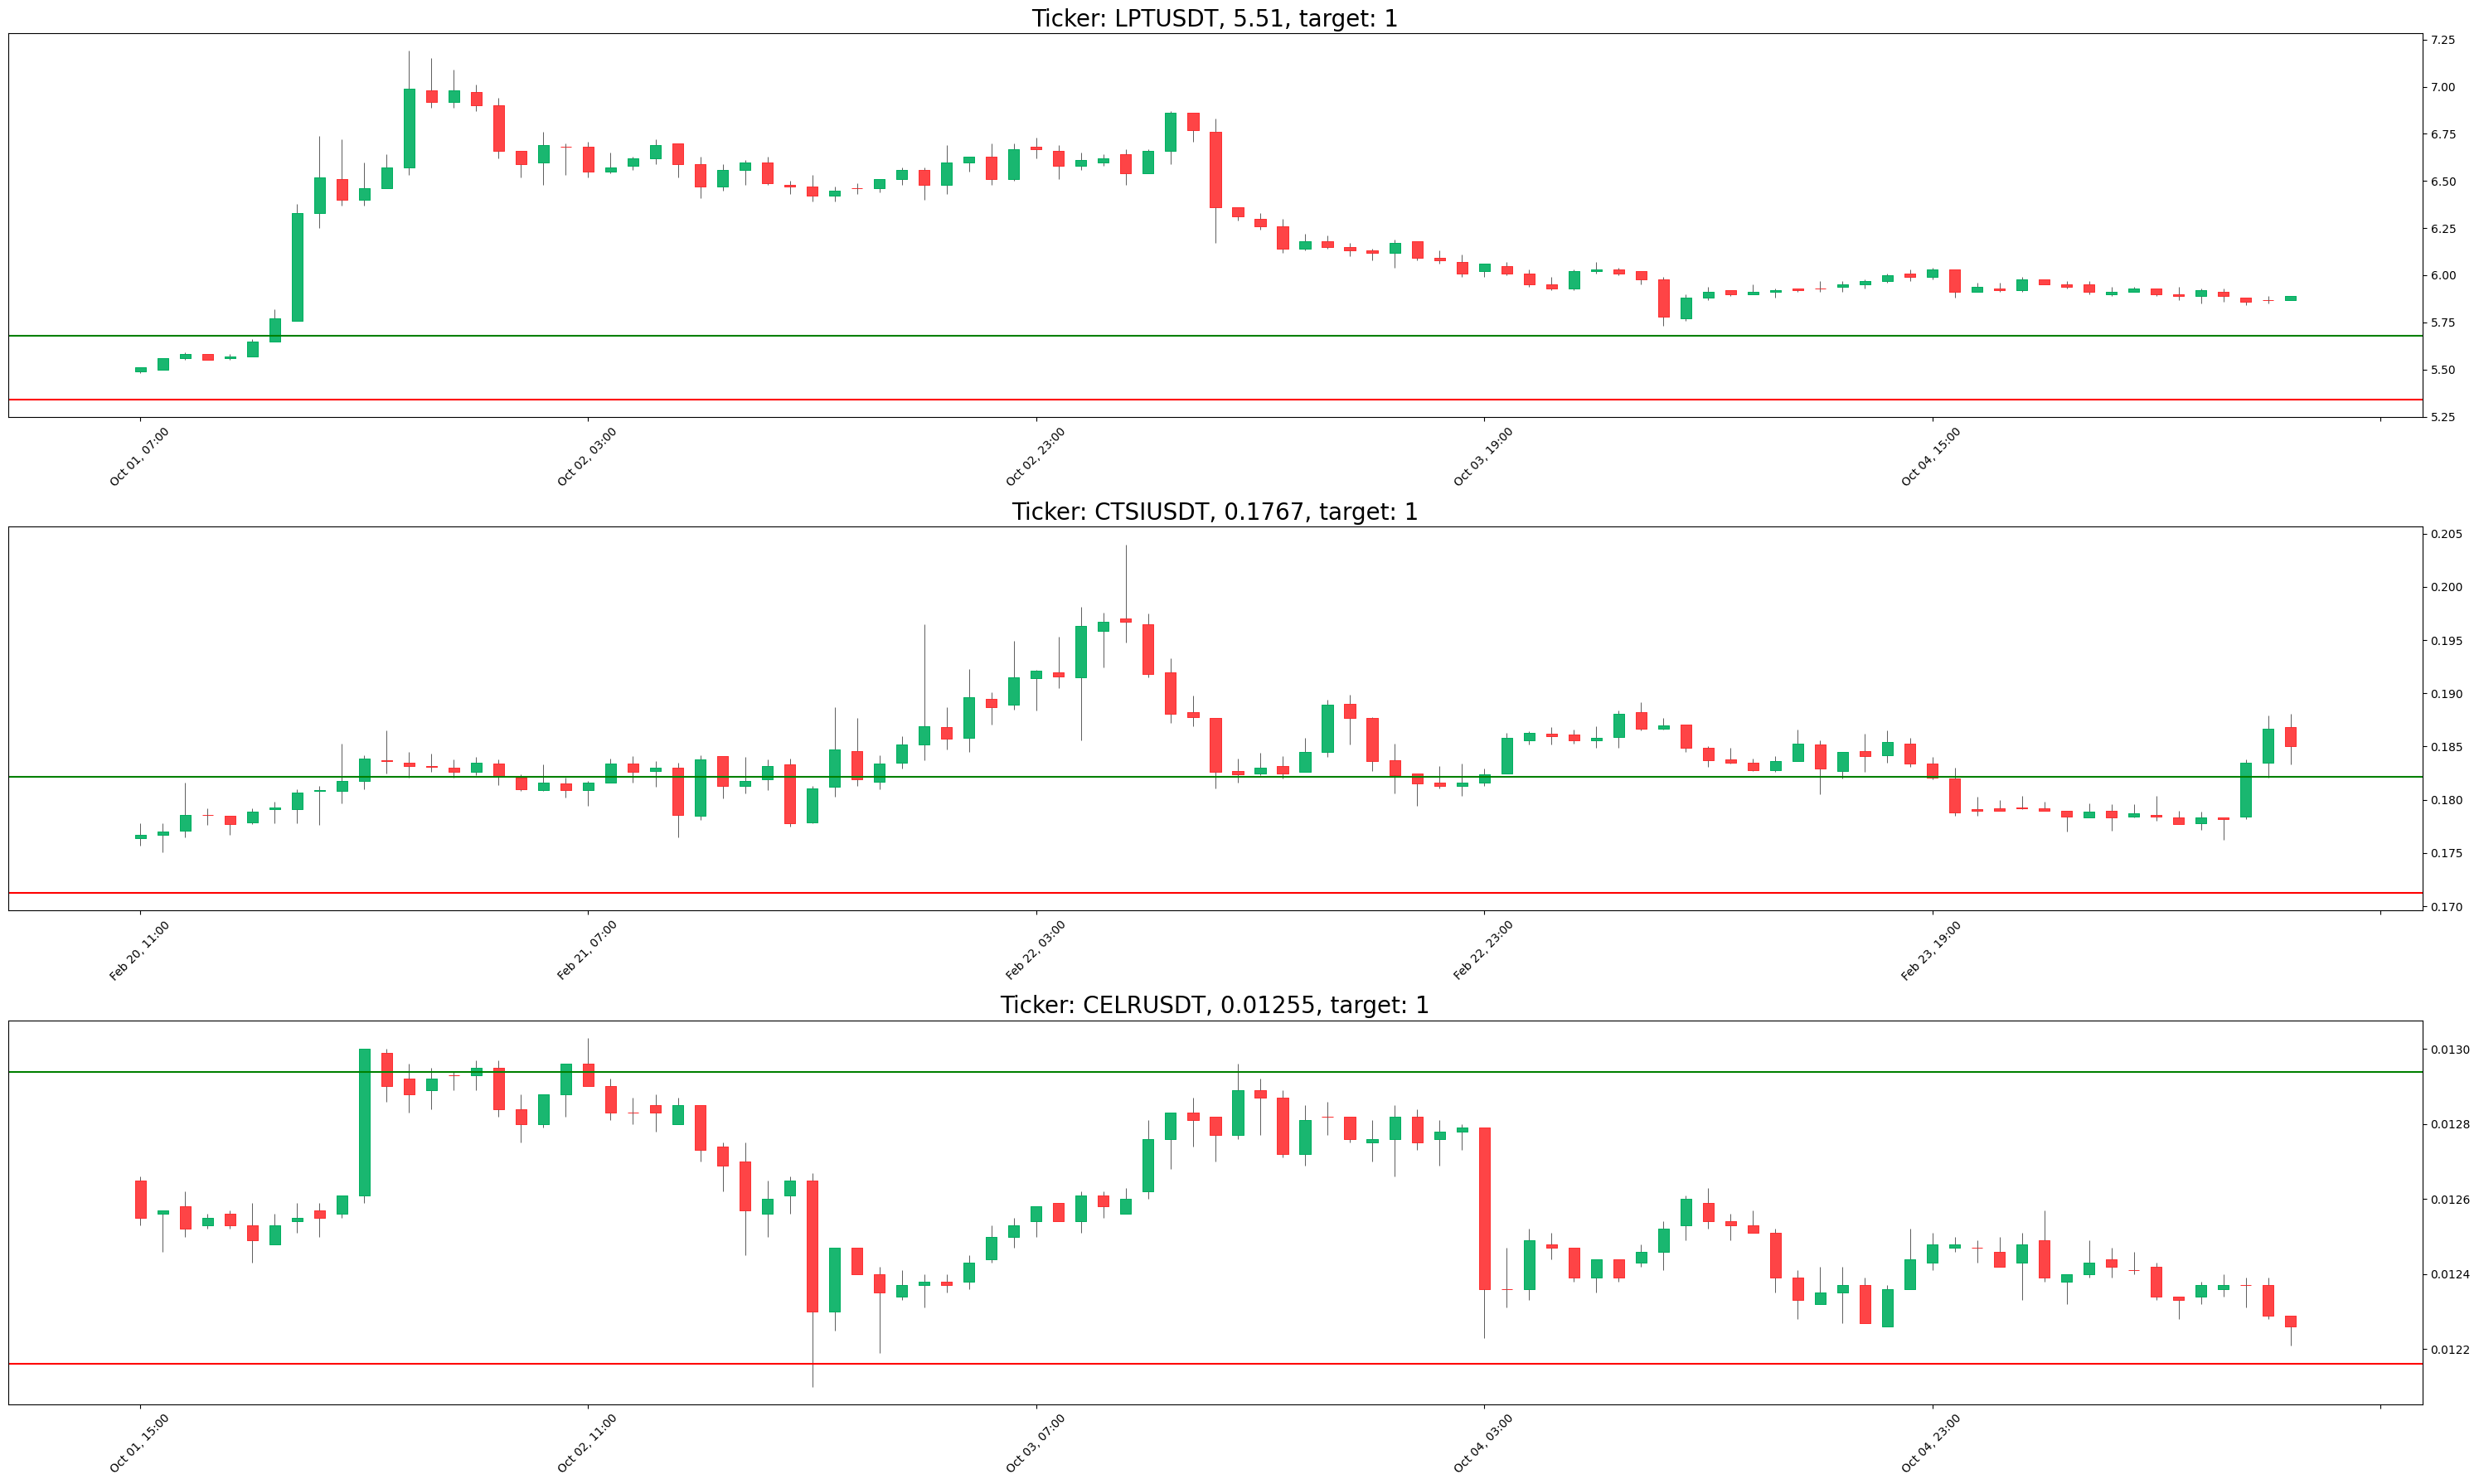

In [8]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import mplfinance as mpf

if CFG.create_dataset:
    plt_num = 3
    j = 1
    fig = plt.figure(figsize=(30, 6 * plt_num))

    buy_idxs = train_buy.index
    test_buy = train_buy.sample(plt_num, axis=0)

    for i, row in test_buy.iterrows():
        ticker = row['ticker']
        time = row['time']
        price = row['close']
        target = row['target']
        ttype = row['ttype']

        high_price = price * CFG.cls_target_ratio_tp
        low_price = price * (2 - CFG.cls_target_ratio_tp)
        
        df_1h, _ = get_file(ticker)
        df_1h = df_1h[(df_1h['time'] >= time) & (df_1h['time'] <= time + timedelta(hours=target_offset))]
        ohlc = df_1h[['time', 'open', 'high', 'low', 'close', 'volume']].set_index('time')

        ax = fig.add_subplot(plt_num, 1, j)
        mpf.plot(ohlc, type='candle', warn_too_much_data=1001, style='yahoo', ylabel='', tz_localize=True, ax=ax)
        
        if ttype == 'buy':
            ax.axhline(high_price, color='g')
            ax.axhline(low_price, color='r')
        else:
            ax.axhline(high_price, color='r')
            ax.axhline(low_price, color='g')
        ax.set_title(f'Ticker: {ticker}, {price}, target: {target}', fontsize=20)
        j += 1
        
    fig.tight_layout()

# Check buy trades correctness

In [9]:
train_buy[['time', 'close', 'ticker', 'target', 'pattern']].tail(5)

,time,close,ticker,target,pattern
2686,2023-11-10 03:00:00,6.605500,FXSUSDT,1,MACD
2687,2023-11-10 07:00:00,1.142000,GTCUSDT,1,MACD
2688,2023-11-10 07:00:00,0.946400,IMXUSDT,1,MACD
2689,2023-11-10 07:00:00,3.180000,QTUMUSDT,1,MACD
2690,2023-11-10 07:00:00,0.004959,JASMYUSDT,1,MACD


# Check sell trades correctness

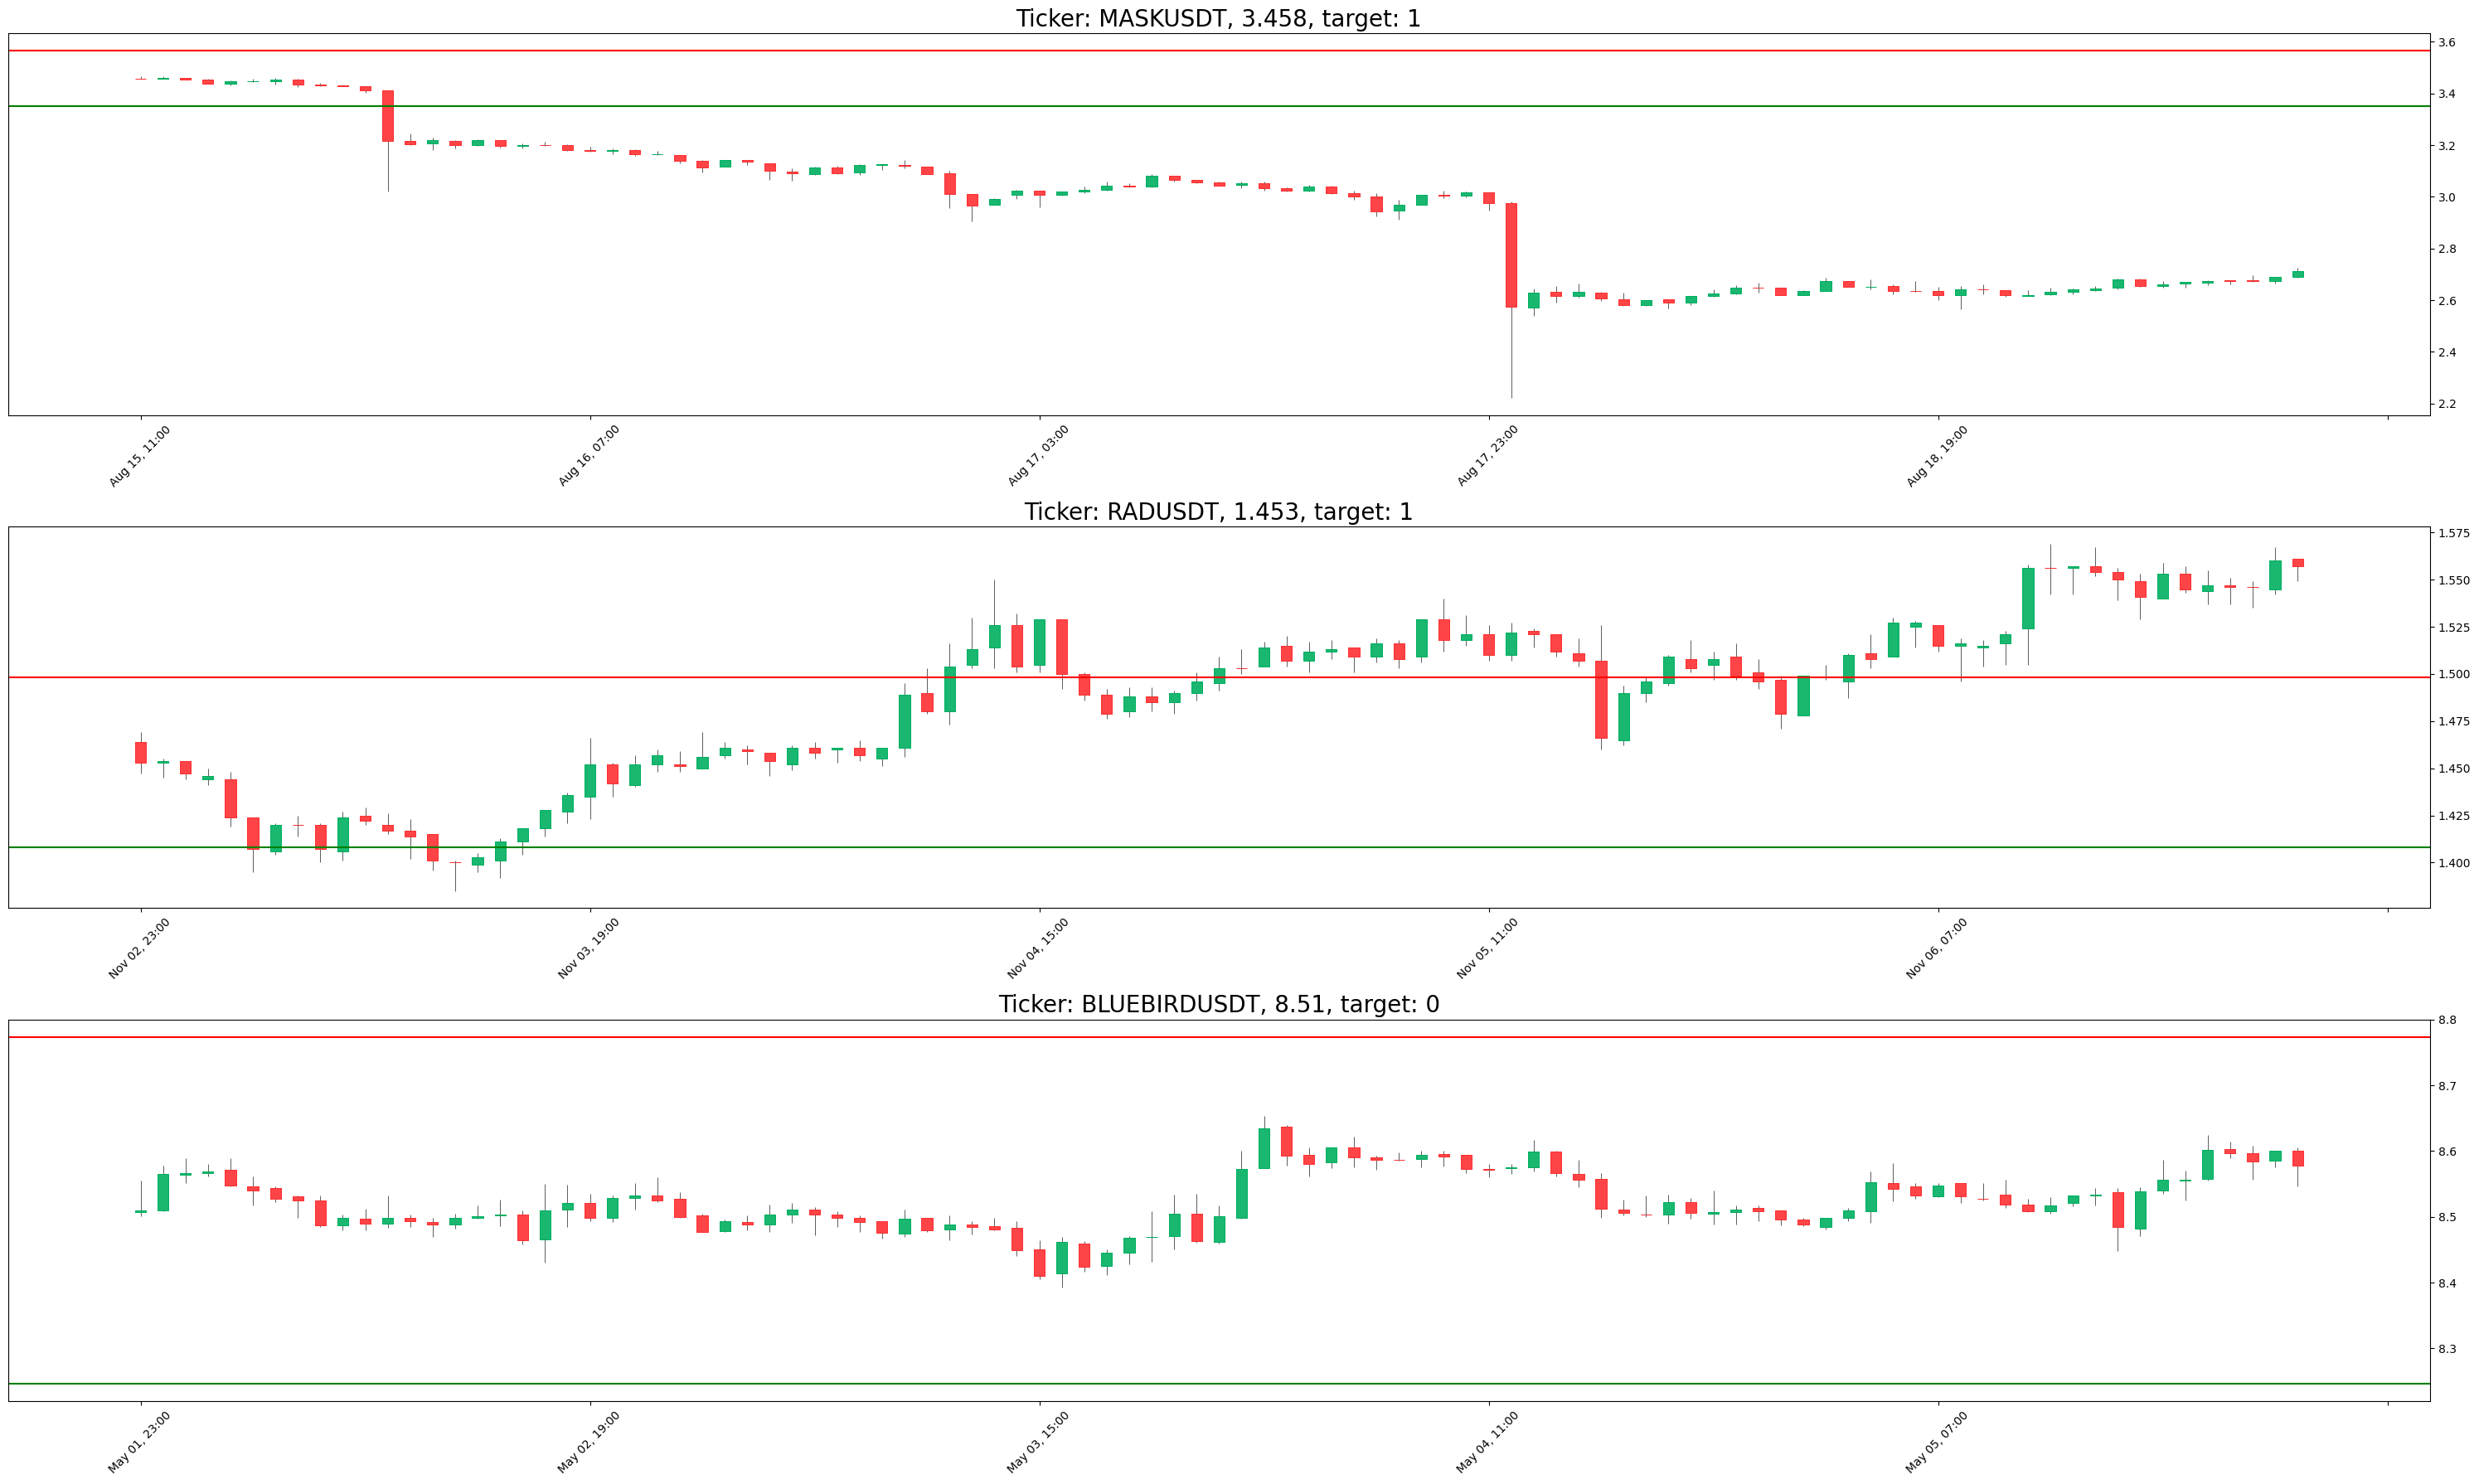

In [10]:
if CFG.create_dataset:
    plt_num = 3
    j = 1
    fig = plt.figure(figsize=(30, 6 * plt_num))

    buy_idxs = train_sell.index
    test_sell = train_sell.sample(plt_num, axis=0)

    for i, row in test_sell.iterrows():
        ticker = row['ticker']
        time = row['time']
        price = row['close']
        target = row['target']
        ttype = row['ttype']

        high_price = price * CFG.cls_target_ratio_tp
        low_price = price * (2 - CFG.cls_target_ratio_tp)
        
        df_1h, _ = get_file(ticker)
        df_1h = df_1h[(df_1h['time'] >= time) & (df_1h['time'] <= time + timedelta(hours=target_offset))]
        ohlc = df_1h[['time', 'open', 'high', 'low', 'close', 'volume']].set_index('time')

        ax = fig.add_subplot(plt_num, 1, j)
        mpf.plot(ohlc, type='candle', warn_too_much_data=1001, style='yahoo', ylabel='', tz_localize=True, ax=ax)
        
        if ttype == 'buy':
            ax.axhline(high_price, color='g')
            ax.axhline(low_price, color='r')
        else:
            ax.axhline(high_price, color='r')
            ax.axhline(low_price, color='g')
        ax.set_title(f'Ticker: {ticker}, {price}, target: {target}', fontsize=20)
        j += 1
        
    fig.tight_layout()

# Concat buy and sell datasets

,time,open,high,low,close,volume,rsi,stoch_slowk,stoch_slowd,stoch_slowk_dir,stoch_slowd_dir,stoch_diff,atr,close_smooth,linear_reg,linear_reg_angle,macd,macdhist,macd_dir,macdsignal,macdsignal_dir,open_prev_4,high_prev_4,low_prev_4,close_prev_4,volume_prev_4,rsi_prev_4,stoch_slowk_prev_4,stoch_slowd_prev_4,stoch_slowk_dir_prev_4,stoch_slowd_dir_prev_4,stoch_diff_prev_4,atr_prev_4,close_smooth_prev_4,linear_reg_prev_4,linear_reg_angle_prev_4,macd_prev_4,macdhist_prev_4,macd_dir_prev_4,macdsignal_prev_4,macdsignal_dir_prev_4,ticker,pattern,open_prev_8,high_prev_8,low_prev_8,close_prev_8,volume_prev_8,rsi_prev_8,stoch_slowk_prev_8,stoch_slowd_prev_8,stoch_slowk_dir_prev_8,stoch_slowd_dir_prev_8,stoch_diff_prev_8,atr_prev_8,close_smooth_prev_8,linear_reg_prev_8,linear_reg_angle_prev_8,macd_prev_8,macdhist_prev_8,macd_dir_prev_8,macdsignal_prev_8,macdsignal_dir_prev_8,open_prev_12,high_prev_12,low_prev_12,close_prev_12,volume_prev_12,rsi_prev_12,stoch_slowk_prev_12,stoch_slowd_prev_12,stoch_slowk_dir_prev_12,stoch_slowd_dir_prev_12,stoch_diff_prev_12,atr_prev_12,close_smooth_prev_12,linear_reg_prev_12,linear_reg_angle_prev_12,macd_prev_12,macdhist_prev_12,macd_dir_prev_12,macdsignal_prev_12,macdsignal_dir_prev_12,open_prev_16,high_prev_16,low_prev_16,close_prev_16,volume_prev_16,rsi_prev_16,stoch_slowk_prev_16,stoch_slowd_prev_16,stoch_slowk_dir_prev_16,stoch_slowd_dir_prev_16,stoch_diff_prev_16,atr_prev_16,close_smooth_prev_16,linear_reg_prev_16,linear_reg_angle_prev_16,macd_prev_16,macdhist_prev_16,macd_dir_prev_16,macdsignal_prev_16,macdsignal_dir_prev_16,open_prev_20,high_prev_20,low_prev_20,close_prev_20,volume_prev_20,rsi_prev_20,stoch_slowk_prev_20,stoch_slowd_prev_20,stoch_slowk_dir_prev_20,stoch_slowd_dir_prev_20,stoch_diff_prev_20,atr_prev_20,close_smooth_prev_20,linear_reg_prev_20,linear_reg_angle_prev_20,macd_prev_20,macdhist_prev_20,macd_dir_prev_20,macdsignal_prev_20,macdsignal_dir_prev_20,open_prev_24,high_prev_24,low_prev_24,close_prev_24,volume_prev_24,rsi_prev_24,stoch_slowk_prev_24,stoch_slowd_prev_24,stoch_slowk_dir_prev_24,stoch_slowd_dir_prev_24,stoch_diff_prev_24,atr_prev_24,close_smooth_prev_24,linear_reg_prev_24,linear_reg_angle_prev_24,macd_prev_24,macdhist_prev_24,macd_dir_prev_24,macdsignal_prev_24,macdsignal_dir_prev_24,open_prev_28,high_prev_28,low_prev_28,close_prev_28,volume_prev_28,rsi_prev_28,stoch_slowk_prev_28,stoch_slowd_prev_28,stoch_slowk_dir_prev_28,stoch_slowd_dir_prev_28,stoch_diff_prev_28,atr_prev_28,close_smooth_prev_28,linear_reg_prev_28,linear_reg_angle_prev_28,macd_prev_28,macdhist_prev_28,macd_dir_prev_28,macdsignal_prev_28,macdsignal_dir_prev_28,open_prev_32,high_prev_32,low_prev_32,close_prev_32,volume_prev_32,rsi_prev_32,stoch_slowk_prev_32,stoch_slowd_prev_32,stoch_slowk_dir_prev_32,stoch_slowd_dir_prev_32,stoch_diff_prev_32,atr_prev_32,close_smooth_prev_32,linear_reg_prev_32,linear_reg_angle_prev_32,macd_prev_32,macdhist_prev_32,macd_dir_prev_32,macdsignal_prev_32,macdsignal_dir_prev_32,open_prev_36,high_prev_36,low_prev_36,close_prev_36,volume_prev_36,rsi_prev_36,stoch_slowk_prev_36,stoch_slowd_prev_36,stoch_slowk_dir_prev_36,stoch_slowd_dir_prev_36,stoch_diff_prev_36,atr_prev_36,close_smooth_prev_36,linear_reg_prev_36,linear_reg_angle_prev_36,macd_prev_36,macdhist_prev_36,macd_dir_prev_36,macdsignal_prev_36,macdsignal_dir_prev_36,open_prev_40,high_prev_40,low_prev_40,close_prev_40,volume_prev_40,rsi_prev_40,stoch_slowk_prev_40,stoch_slowd_prev_40,stoch_slowk_dir_prev_40,stoch_slowd_dir_prev_40,stoch_diff_prev_40,atr_prev_40,close_smooth_prev_40,linear_reg_prev_40,linear_reg_angle_prev_40,macd_prev_40,macdhist_prev_40,macd_dir_prev_40,macdsignal_prev_40,macdsignal_dir_prev_40,open_prev_44,high_prev_44,low_prev_44,close_prev_44,volume_prev_44,rsi_prev_44,stoch_slowk_prev_44,stoch_slowd_prev_44,stoch_slowk_dir_prev_44,stoch_slowd_dir_prev_44,stoch_diff_prev_44,atr_prev_44,close_smooth_prev_44,linear_reg_prev_44,linear_reg_angle_prev_44,macd_prev_44,macdhist_prev_44,macd_dir_prev_

<AxesSubplot:>

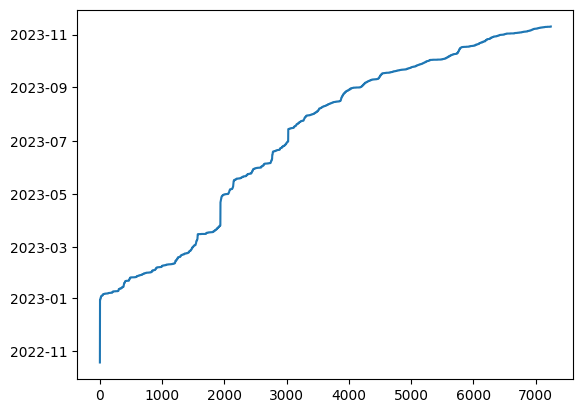

In [11]:
# last previous data point to collect for model training (value represents number of hours before signal point)
last = 192

if CFG.ttype == 'both':
    df_buy = pd.read_pickle(f'signal_stat/train_buy_{last}.pkl')
    df_sell = pd.read_pickle(f'signal_stat/train_sell_{last}.pkl')
    df = pd.concat([df_buy, df_sell])
elif CFG.ttype == 'buy':
    df = pd.read_pickle(f'signal_stat/train_buy_{last}.pkl')
else:
    df = pd.read_pickle(f'signal_stat/train_sell_{last}.pkl')


df = df[df['pattern'].isin(CFG.patterns_to_filter)]

display(df)

df = df.sort_values('time').reset_index(drop=True)
train_df = df

df['time'].plot()


# Pytorch

### Create dataset

In [12]:
test_size=0.2

x_data = train_df.drop(['target', 'time', 'ticker', 'pattern', 'ttype'], axis=1)
y_data = train_df['target']
x_train, x_valid, y_train, y_valid = train_test_split(x_data, y_data, test_size=test_size, shuffle=True)
input_channels = x_data.shape[1]
output_size = len(set(y_data))

scaler = StandardScaler()
x_train[x_train.columns] = scaler.fit_transform(x_train)
x_valid[x_valid.columns] = scaler.transform(x_valid)

x_train = torch.tensor(x_train.values, dtype=torch.float32)
x_valid = torch.tensor(x_valid.values, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.float32)
y_valid = torch.tensor(y_valid.values, dtype=torch.float32)

display(type(x_train), type(y_train))

torch.Tensor

torch.Tensor

### Find available device

In [13]:
# find available device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

### Build model

In [14]:
class SigModel(torch.nn.Module):
    def __init__(self, input_channels):
        super(SigModel, self, ).__init__()
        self.layers = torch.nn.Sequential()
        self.layers.add_module('lin1', torch.nn.Linear(input_channels, 64))
        self.layers.add_module('relu1', torch.nn.ReLU())
        self.layers.add_module('do1', torch.nn.Dropout(p=0.25))
        self.layers.add_module('lin2', torch.nn.Linear(64, 128))
        self.layers.add_module('relu2', torch.nn.ReLU())
        self.layers.add_module('do2', torch.nn.Dropout(p=0.25))
        self.layers.add_module('lin3', torch.nn.Linear(128, 96))
        self.layers.add_module('relu3', torch.nn.ReLU())
        self.layers.add_module('do3', torch.nn.Dropout(p=0.25))
        self.layers.add_module('lin4', torch.nn.Linear(96, 32))
        self.layers.add_module('relu4', torch.nn.ReLU())
        self.layers.add_module('do4', torch.nn.Dropout(p=0.25))
        self.layers.add_module('lin5', torch.nn.Linear(32, 1))
        self.layers.add_module('sigmoid', torch.nn.Sigmoid())
    
    def forward(self, input):
        return self.layers(input)

# Train model

In [15]:
from torch import nn
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau, CosineAnnealingLR

# train function
def train_epoch(model, train_loader, criterion, optimizer, scheduler):
    # put the model in train mode
    model.train()
    
    x_train, x_valid, y_train, y_valid = train_loader

    # get output of the model
    train_preds = model(x_train).squeeze()
    # calculate train loss
    train_loss = criterion(train_preds, y_train)
    train_acc = (train_preds.round() == y_train).float().mean()
    
    # set gradient to zero to prevent it accumulation
    optimizer.zero_grad() # ~ model.zero_grad()
    # calculate gradient
    train_loss.backward() 
    # update weights
    optimizer.step()
    
    # put the model in evaluation mode
    model.eval()

    with torch.no_grad():
        val_preds = model(x_valid).squeeze()
        val_loss = criterion(val_preds, y_valid)
        val_acc = (val_preds.round() == y_valid).float().mean()
    
    # update weights according to gradient value
    scheduler.step(val_loss)
    
    return train_loss, train_acc, val_loss, val_acc

# Initialize model
if CFG.train_NN:
    model = SigModel(input_channels).to(device)

    # Number of epochs
    epochs = 100000

    # Send data to the device
    x_train, x_valid = x_train.to(device), x_valid.to(device)
    y_train, y_valid = y_train.to(device), y_valid.to(device)
    train_loader = x_train, x_valid, y_train, y_valid

    # Empty loss lists to track values
    epoch_count, train_loss_values, valid_loss_values = [], [], []

    criterion = nn.BCELoss()
    learning_rate = 1e-6
    optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2000, threshold=1e-2)

    # Loop through the data
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc, val_loss, val_acc = train_epoch(model, train_loader, criterion, optimizer, scheduler)

        # Print progress a total of 20 times
        if epoch % int(epochs / 20) == 0:
            print(f'Epoch: {epoch:4.0f} | Train Loss: {train_loss:.5f}, Train Acc: {train_acc:.5f}\
                Validation Loss: {val_loss:.5f}, Val Acc: {val_acc:.5f}\
                    LR: {optimizer.state_dict()["param_groups"][0]["lr"]}')

            epoch_count.append(epoch)
            train_loss_values.append(train_loss.cpu().detach().numpy())
            valid_loss_values.append(val_loss.cpu().detach().numpy())


# Plot NN train results

In [16]:
import matplotlib.pyplot as plt

if CFG.train_NN:
    plt.plot(epoch_count, train_loss_values, label='Training Loss')
    plt.plot(epoch_count, valid_loss_values, label='Validation Loss')
    plt.title('Training & Validation Loss Curves')
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.legend()
    plt.show()

# Select features with BORUTA feature importance

In [17]:
import pandas as pd
import lightgbm as lgb
from shaphypetune import BoostBoruta

if CFG.select_features:

  df.to_csv('df.csv', index=False)
  df_boruta = pd.read_csv('df.csv')
  os.remove('df.csv')
  
  params = {
            'n_estimators': 1000,
            'learning_rate': 0.02,
          #   'early_stopping_round': 100,
            'max_depth': 10,
            'subsample' : 0.7,
            'colsample_bytree': 0.85,
            'num_leaves': 24,
            'verbosity': -1,
            'importance_type': 'gain',
            'max_bin': 255,
            'reg_alpha': 1e-6,
            'reg_lambda': 1e-8
          }

  boruta_df_ = pd.DataFrame()

  features = [c for c in df.columns if c not in ['time', 'target', 'ticker', 'pattern', 'ttype']]
  # drop_features = [c for c in df.columns[-75:]]
  # features = features[:10]

  X, y, groups = df_boruta[features], df_boruta['target'], df_boruta['ticker']

  kf = StratifiedGroupKFold(n_splits=CFG.n_folds, shuffle=True, random_state=180820231)
  eval_metric = 'logloss'

  # Stratify based on Class and Alpha (3 types of conditions)
  for fold, (train_idx, val_idx) in enumerate(kf.split(X, y, groups)):
      print(f'Fold: {fold}')
      # Split the dataset according to the fold indexes.
      X_train = X.iloc[train_idx]
      X_val = X.iloc[val_idx]
      y_train = y.iloc[train_idx]
      y_val = y.iloc[val_idx]

      clf = lgb.LGBMClassifier(**params)
      model = BoostBoruta(clf, importance_type='shap_importances', train_importance=False)
      model.fit(X_train, y_train, eval_set=[(X_val, y_val)], 
              eval_metric='logloss', 
              callbacks=[lgb.log_evaluation(100)])

      boruta_importance_df = pd.DataFrame({'importance': model.ranking_}, index=X_train.columns).sort_index()
      if boruta_df_.shape[0] == 0:
          boruta_df_ = boruta_importance_df.copy()
      else:
          boruta_df_ += boruta_importance_df

  boruta_df_ = boruta_df_.sort_values('importance')
  boruta_df_ = boruta_df_.reset_index().rename({'index': 'Feature'}, axis=1)

  del df_boruta

# Select features with permutation importance and GBM feature importance

In [18]:
palette = ['#302c36', '#037d97', '#E4591E', '#C09741',
           '#EC5B6D', '#90A6B1', '#6ca957', '#D8E3E2']

blk = Style.BRIGHT + Fore.BLACK
red = Style.BRIGHT + Fore.RED
blu = Style.BRIGHT + Fore.BLUE
res = Style.RESET_ALL

def lgbm_tuning(df, permut=False):
    features = [c for c in df.columns if c not in ['time', 'target', 'ticker', 'pattern', 'ttype']]
    groups = df['ticker']

    outer_cv_score = [] # store all cv scores of outer loop inference

    perm_df_ = pd.DataFrame()
    feature_importances_ = pd.DataFrame()
    
    for i in range(CFG.n_repeats):
        print(f'Repeat {blu}#{i+1}')
        
        y_fold = df['target']
        kf = StratifiedGroupKFold(n_splits=CFG.n_folds, shuffle=True, random_state=180820231)
        eval_metric = 'logloss'

        X, y = df[features], y_fold
        oof = np.zeros(len(df))
        
        # Stratify based on Class and Alpha (3 types of conditions)
        for fold, (train_idx, val_idx) in enumerate(kf.split(X, y, groups)):
            # Split the dataset according to the fold indexes.
            X_train = X.iloc[train_idx]
            X_val = X.iloc[val_idx]
            y_train = y.iloc[train_idx]
            y_val = y.iloc[val_idx]

            clf = lgb.LGBMClassifier(**params)
            clf.fit(X_train, y_train, eval_set=[(X_val, y_val)], 
                    eval_metric=eval_metric, 
                    callbacks=[lgb.log_evaluation(100)])

            val_preds = clf.predict_proba(X_val)[:,1]
            val_score = log_loss(y_val, val_preds)
            
            oof[val_idx] = val_preds
            best_iter = clf.best_iteration_

            print(f'Fold: {blu}{fold + 1:>3}{res}| loss: {blu}{val_score:.5f}{res}| Best iteration: {blu}{best_iter:>4}{res}')

            # gboost feature importance
            f_i = pd.DataFrame(sorted(zip(clf.feature_importances_, X.columns), 
                                      reverse=True, key=lambda x: x[1]), 
                                columns=['Value','Feature'])

            if feature_importances_.shape[0] == 0:
                feature_importances_ = f_i.copy()
            else:
                feature_importances_['Value'] += f_i['Value']
            
            # permutation importance
            if permut:
                perm = PermutationImportance(clf, scoring=None, n_iter=1, 
                                             random_state=42, cv=None, refit=False).fit(X_val, y_val)

                perm_importance_df = pd.DataFrame({'importance': perm.feature_importances_}, 
                                                    index=X_val.columns).sort_index()

                if perm_df_.shape[0] == 0:
                    perm_df_ = perm_importance_df.copy()
                else:
                    perm_df_ += perm_importance_df

        outer_cv = log_loss(y, oof)
        outer_cv_score.append(outer_cv)

    print(f'{red} Outer Holdout avg score: {res} log_loss: {red}{np.mean(outer_cv_score):.5f}{res}')
    print(f'{"*" * 50}\n')
    
    if permut:
        perm_df_ = perm_df_.sort_values('importance', ascending=False)
        perm_df_ = perm_df_.reset_index().rename({'index': 'Feature'}, axis=1)
                                    
    feature_importances_ = feature_importances_.sort_values('Value', ascending=False).reset_index(drop=True)
    
    return perm_df_, feature_importances_, np.mean(outer_cv_score)


params = {
          'n_estimators': 1000,
          'learning_rate': 0.02,
        #   'early_stopping_round': 100,
          'max_depth': 9,
          'subsample' : 0.7,
          'colsample_bytree': 0.85,
          'num_leaves': 24,
          'verbosity': -1,
          'importance_type': 'gain',
          'max_bin': 255,
          'reg_alpha': 1e-6,
          'reg_lambda': 1e-8
        }

task_type = 'cls'

if task_type == 'cls':
    params['boosting_type'] = 'dart'
    params['objective'] = 'binary'
else:
    params['boosting_type'] = 'gbdt'
    params['objective'] = 'regression'

if CFG.select_features:
    perm_df_, feature_importances_, outer_cv_score = lgbm_tuning(df, permut=True)

# Combine importances and save them

In [19]:
if CFG.select_features:
    perm_df_['rank'] = perm_df_['importance'].rank(ascending=False)
    boruta_df_['rank'] = boruta_df_['importance'].rank()
    feature_importances_['rank'] = feature_importances_['Value'].rank(ascending=False)

    fi = pd.concat([perm_df_[['Feature','rank']], feature_importances_[['Feature','rank']], boruta_df_[['Feature','rank']]])
    fi = fi.groupby('Feature')['rank'].sum().sort_values().reset_index()
    fi.to_csv(f'feature_importance_{CFG.ttype}.csv')
else:
    fi = pd.read_csv(f'feature_importance_{CFG.ttype}.csv')

# Train_test split based on ticker groups

In [26]:
idxs = list()

def model_train(df, train_df, features, task_type, how, n_folds, low_bound, high_bound, train_test): 
    X, time = train_df[features], train_df['time']
    # X = pd.concat([X, pd.get_dummies(train_df[['ttype']], drop_first=True)], axis=1)
    y = train_df['target']
    
    if train_test == 'fold':
        oof = np.zeros([len(train_df), 1])

        tss = TimeSeriesSplit(gap=0, max_train_size=None, n_splits=n_folds, test_size=(len(train_df) * 2) // (n_folds * 3))

        print(f"Training with {len(features)} features")
        
        for fold, (fit_idx, val_idx) in enumerate(tss.split(time)):
            idxs.append((fit_idx, val_idx))
            
            if fold == 0:
                first_val_idx = val_idx[0]
            
            print(f'Fold #{fold + 1}')
            # Split the dataset according to the fold indexes.
            X_train = X.iloc[fit_idx]
            X_val = X.iloc[val_idx]
            y_train = y.iloc[fit_idx]
            y_val = y.iloc[val_idx]

            display(y_val.value_counts())
            display(train_df.loc[val_idx[0], 'time'])
            display(train_df.loc[val_idx[-1], 'time'])
            
            model = lgb.LGBMClassifier(**params)
            model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)], 
                        eval_metric='logloss')#, callbacks = [lgb.log_evaluation(100)])

            val_preds = model.predict_proba(X_val)
            val_score = log_loss(y_val, val_preds)
            prec_score, prec_obj_pct = confident_score(y_val, val_preds[:,1], low_bound, high_bound)
            print(f'Logloss: {val_score}, Confident objects precision: {prec_score}, % of confident objects: {prec_obj_pct}\n')
            oof[val_idx, 0] = val_preds[:,1]

        return oof, model, first_val_idx
    elif train_test == 'full':
        print('Train on full data')
        X, y = df[features], df['target']
        model = lgb.LGBMClassifier(**params)
        model.fit(X, y, eval_set=[(X, y)], eval_metric='logloss', callbacks = [lgb.log_evaluation(100)])
        return np.zeros([df.shape[0], 1]), model, None

def prepare_features(fi, feature_num, features_to_exclude):
    ''' Get features, sort them by their time appearance and return for using in train and inference'''
    fi = fi['Feature'].head(feature_num)
    feature_dict = defaultdict(list)
    features = list()

    # exclude some features by their numbers
    feature_idx = [i for i in range(feature_num) if i not in features_to_exclude]
    fi = (np.array(fi)[feature_idx])
    
    for f in fi:
        period = f.split('_')
        if period[-1].isdigit():
            feature_dict[int(period[-1])].append('_'.join(period[:-2]))
        else:
            feature_dict[0].append(f)

    feature_dict = dict(sorted(feature_dict.items()))
    
    for item in feature_dict.items():
        if item[0] > 0:
            features.extend([i + f'_prev_{item[0]}' for i in item[1]])
        else:
            features.extend([i for i in item[1]])

    feature_dict['features'] = features # + ['Pattern_Trend', 'STOCH_RSI']

    return features, feature_dict

def confident_score(y, oof, low_bound, high_bound):
    ''' Consider only high confident objects for accuracy and precision scores calculation;
        object probability must be lower than low_bound or higher than high_bound '''
    pred_conf = np.zeros_like(oof)
    pred_conf[oof > high_bound] = 1
    pred_conf[oof < low_bound] = 0
    pred_conf_prec = pred_conf[(oof > high_bound)]
    y_conf_prec = y.values.reshape(-1,1)[(oof > high_bound)]

    return precision_score(y_conf_prec, pred_conf_prec), y_conf_prec.shape[0]/y.shape[0]

train_test = 'fold' # fold, test, full, inference
feature_num = 165

low_bound, high_bound = 0.31, 0.69
params = {
    'boosting_type': 'dart',
    'n_estimators': 1500,
    'learning_rate': 0.02,
    # 'early_stopping_round': 50,
    'max_depth': 10,
    'colsample_bytree': 0.8,
    'subsample': 0.85,
    'subsample_freq': 1,
    'num_leaves': 23,
    'verbosity': -1,
    'max_bin': 255,
    'reg_alpha': 1e-6,
    'reg_lambda': 1e-7,
    'objective': 'binary',
    # 'is_unbalance': True,
    # 'class_weight': 'balanced',
    'metric': 'average_precision'
    }

if CFG.train_LGBM:
    # feature_exclude_dict = dict()
    # for j in tqdm(range(1, 162)):
    #     print(j)
    features_to_exclude = [10]
    fi = pd.read_csv(f'feature_importance_{CFG.ttype}.csv')
    features, feature_dict = prepare_features(fi, feature_num, features_to_exclude)
    
    if train_test != 'inference':
        oof, model, first_val_idx = model_train(df, train_df, features, task_type=task_type, how='lgbm', n_folds=5, low_bound=low_bound, high_bound=high_bound, train_test=train_test)
    if train_test == 'fold':
        # fold
        y = train_df['target'][first_val_idx:]
        oof = oof[first_val_idx:]
        oof_val_score = log_loss(y, oof)
        oof_conf_prec_score, oof_conf_obj_pct = confident_score(y, oof, low_bound, high_bound)
        print(f'Total fold Logloss: {oof_val_score}, Total confident objects precision: {oof_conf_prec_score}, Total % of confident objects: {oof_conf_obj_pct}')
        # feature_exclude_dict[j] = (oof_val_score, oof_conf_prec_score, oof_conf_obj_pct)
    elif train_test == 'full':
        joblib.dump(model, f'lgbm.pkl')
        # save feature dictionary for further inference
        with open(f'features.json', 'w') as f:
            json.dump(feature_dict, f)
    

Training with 164 features
Fold #1


1    606
0    359
Name: target, dtype: int64

Timestamp('2023-05-24 15:00:00')

Timestamp('2023-07-31 07:00:00')

Logloss: 0.647326841751713, Confident objects precision: 0.6986301369863014, % of confident objects: 0.37823834196891193

Fold #2


1    574
0    391
Name: target, dtype: int64

Timestamp('2023-07-31 07:00:00')

Timestamp('2023-09-09 07:00:00')

Logloss: 0.7235159491766702, Confident objects precision: 0.631578947368421, % of confident objects: 0.3544041450777202

Fold #3


1    497
0    468
Name: target, dtype: int64

Timestamp('2023-09-09 07:00:00')

Timestamp('2023-10-02 19:00:00')

Logloss: 0.717722542432258, Confident objects precision: 0.5652173913043478, % of confident objects: 0.2860103626943005

Fold #4


1    613
0    352
Name: target, dtype: int64

Timestamp('2023-10-02 19:00:00')

Timestamp('2023-10-27 23:00:00')

Logloss: 0.6465182402199344, Confident objects precision: 0.8358974358974359, % of confident objects: 0.20207253886010362

Fold #5


1    550
0    415
Name: target, dtype: int64

Timestamp('2023-10-27 23:00:00')

Timestamp('2023-11-10 07:00:00')

Logloss: 0.6579193952042851, Confident objects precision: 0.7134502923976608, % of confident objects: 0.1772020725388601

Total fold Logloss: 0.6786005937569721, Total confident objects precision: 0.676056338028169, Total % of confident objects: 0.2795854922279793


In [21]:
# params = {
#     'boosting_type': 'dart',
#     'n_estimators': 1600,
#     'learning_rate': 0.02,
#     'max_depth': 10,
#     'colsample_bytree': 0.75,
#     'subsample': 0.85,
#     'subsample_freq': 1,
#     'num_leaves': 23,
#     'verbosity': -1,
#     'max_bin': 255,
#     'reg_alpha': 1e-6,
#     'reg_lambda': 1e-7,
#     'objective': 'binary',
#     'metric': 'average_precision'
#     }

# Training with 164 features
# Fold #1
# Logloss: 0.6534129811417911, Confident objects precision: 0.6923076923076923, % of confident objects: 0.48259860788863107

# Fold #2
# Logloss: 0.6649647745822687, Confident objects precision: 0.7041420118343196, % of confident objects: 0.39211136890951276

# Fold #3
# Logloss: 0.7335666007479286, Confident objects precision: 0.6016260162601627, % of confident objects: 0.2853828306264501

# Fold #4
# Logloss: 0.67917822039063, Confident objects precision: 0.7051282051282052, % of confident objects: 0.271461716937355

# Fold #5
# Logloss: 0.6702416454830529, Confident objects precision: 0.7232704402515723, % of confident objects: 0.18445475638051045

# Total fold Logloss: 0.6802728444691342, Total confident objects precision: 0.6848528356066045, Total % of confident objects: 0.3232018561484919

# Count predictions according to pattern

In [22]:
train_df['target'].value_counts()

1    4252
0    2992
Name: target, dtype: int64

In [23]:
if train_test == 'fold':
    train_df.loc[first_val_idx:,'oof'] = oof >= high_bound
    display(train_df.groupby('pattern')['oof'].agg(['mean', 'count']))

,mean,count
pattern,,
MACD,0.152083,480


In [24]:
thresh = 0.69

x = df.loc[first_val_idx:,['time', 'close', 'volume', 'ticker', 'ttype', 'target']]
x['pred'] = oof
display(x.loc[x['pred'] > thresh, 'target'].value_counts())
x.loc[x['pred'] > thresh, 'target'].value_counts(normalize=True)

1    55
0    18
Name: target, dtype: int64

1    0.753425
0    0.246575
Name: target, dtype: float64